In [1]:
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.initialization import jobs_jssp_init as init
from src.utils.analysis_basics import check_constraints as check
from src.utils.rolling_process.rolling_filter import *

from src.utils.initialization.arrivals_init import calculate_mean_interarrival_time, generate_arrivals_from_mean_interarrival_time

# Solver
from src.solvers.converter import get_schedule_dframe, get_earliest_start_dict, get_job_ops_dict
from src.solvers.cp.makespan import solve_jssp_makespan_minimization
from src.solvers.cp.flowtime import solve_jssp_flowtime_minimization

# Data access
from configs.path_manager import get_path

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
# Hard termination condition for schedulers
max_time = 60*10    # 10 min

# File paths
examples_data_path = get_path("data", "examples")
basic_data_path = get_path("data", "basic")


In [3]:
# Load file
df_routings = pd.read_csv(basic_data_path / "routings_ft10.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


### Generation of job-shop scheduling problem and the associated jobs information

In [4]:
df_jssp = init.generate_jobs_from_routings(df_routings, shuffle = False)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,0,0,M00,29
1,J25-0000,0,1,M01,78
2,J25-0000,0,2,M02,9
3,J25-0000,0,3,M03,36
4,J25-0000,0,4,M04,49
5,J25-0000,0,5,M05,11
...,...,...,...,...,...
94,J25-0009,9,4,M08,64
95,J25-0009,9,5,M09,76
96,J25-0009,9,6,M05,47


In [5]:
df_jobs_arrivals = df_jssp[["Job", "Routing_ID"]].drop_duplicates()

mean_arrival_time = calculate_mean_interarrival_time(df_routings, u_b_mmax =  0.95)
print("Mean arrival time:", mean_arrival_time)

df_jobs_arrivals["Arrival"] = 0
# df_jobs_arrivals["Arrival"] = generate_arrivals_from_mean_interarrival_time(len(df_jobs_arrivals),mean_interarrival_time)


df_jobs_arrivals


Mean arrival time: 66.42


,Job,Routing_ID,Arrival
0,J25-0000,0,0
10,J25-0001,1,0
20,J25-0002,2,0
30,J25-0003,3,0
40,J25-0004,4,0
50,J25-0005,5,0
60,J25-0006,6,0
70,J25-0007,7,0
80,J25-0008,8,0
90,J25-0009,9,0


### Scheduling Preparation

In [6]:
job_ops = get_job_ops_dict(df_jssp)
job_ops

{'J25-0000': [(0, 'M00', 29),
  (1, 'M01', 78),
  (2, 'M02', 9),
  (3, 'M03', 36),
  (4, 'M04', 49),
  (5, 'M05', 11),
  (6, 'M06', 62),
  (7, 'M07', 56),
  (8, 'M08', 44),
  (9, 'M09', 21)],
 'J25-0001': [(0, 'M00', 43),
  (1, 'M02', 90),
  (2, 'M04', 75),
  (3, 'M09', 11),
  (4, 'M03', 69),
  (5, 'M01', 28),
  (6, 'M06', 46),
  (7, 'M05', 46),
  (8, 'M07', 72),
  (9, 'M08', 30)],
 'J25-0002': [(0, 'M01', 91),
  (1, 'M00', 85),
  (2, 'M03', 39),
  (3, 'M02', 74),
  (4, 'M08', 90),
  (5, 'M05', 10),
  (6, 'M07', 12),
  (7, 'M06', 89),
  (8, 'M09', 45),
  (9, 'M04', 33)],
 'J25-0003': [(0, 'M01', 81),
  (1, 'M02', 95),
  (2, 'M00', 71),
  (3, 'M04', 99),
  (4, 'M06', 9),
  (5, 'M08', 52),
  (6, 'M07', 85),
  (7, 'M03', 98),
  (8, 'M09', 22),
  (9, 'M05', 43)],
 'J25-0004': [(0, 'M02', 14),
  (1, 'M00', 6),
  (2, 'M01', 22),
  (3, 'M05', 61),
  (4, 'M03', 26),
  (5, 'M04', 69),
  (6, 'M08', 21),
  (7, 'M07', 49),
  (8, 'M09', 72),
  (9, 'M06', 53)],
 'J25-0005': [(0, 'M02', 84),
  (1, 'M

In [7]:
job_earliest_starts = get_earliest_start_dict(df_jobs_arrivals, earliest_start_column = "Arrival")
job_earliest_starts

{'J25-0000': 0,
 'J25-0001': 0,
 'J25-0002': 0,
 'J25-0003': 0,
 'J25-0004': 0,
 'J25-0005': 0,
 'J25-0006': 0,
 'J25-0007': 0,
 'J25-0008': 0,
 'J25-0009': 0}

## Scheduling

### a) Makespan

In [8]:
log_file_path = None # logs_path / "makespan_cp.log"

schedule = solve_jssp_makespan_minimization(
    job_ops=job_ops,
    earliest_start=job_earliest_starts,
    schedule_start=0,
    solver_time_limit=max_time,
    msg=True,
    log_file=log_file_path
)
df_schedule = get_schedule_dframe(schedule)
df_schedule

Model Information
  Number of variables       : 201
  Number of constraints     : 310

Solver Information:
  Status                   : OPTIMAL
  Objective value          : 930.0
  Best objective bound     : 930.0
  Number of branches       : 0
  Wall time                : 2.6294585


,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,119,29,148
1,J25-0000,1,M01,445,78,523
2,J25-0000,2,M02,523,9,532
3,J25-0000,3,M03,534,36,570
4,J25-0000,4,M04,570,49,619
5,J25-0000,5,M05,619,11,630
...,...,...,...,...,...,...
94,J25-0009,4,M08,429,64,493
95,J25-0009,5,M09,551,76,627
96,J25-0009,6,M05,630,47,677


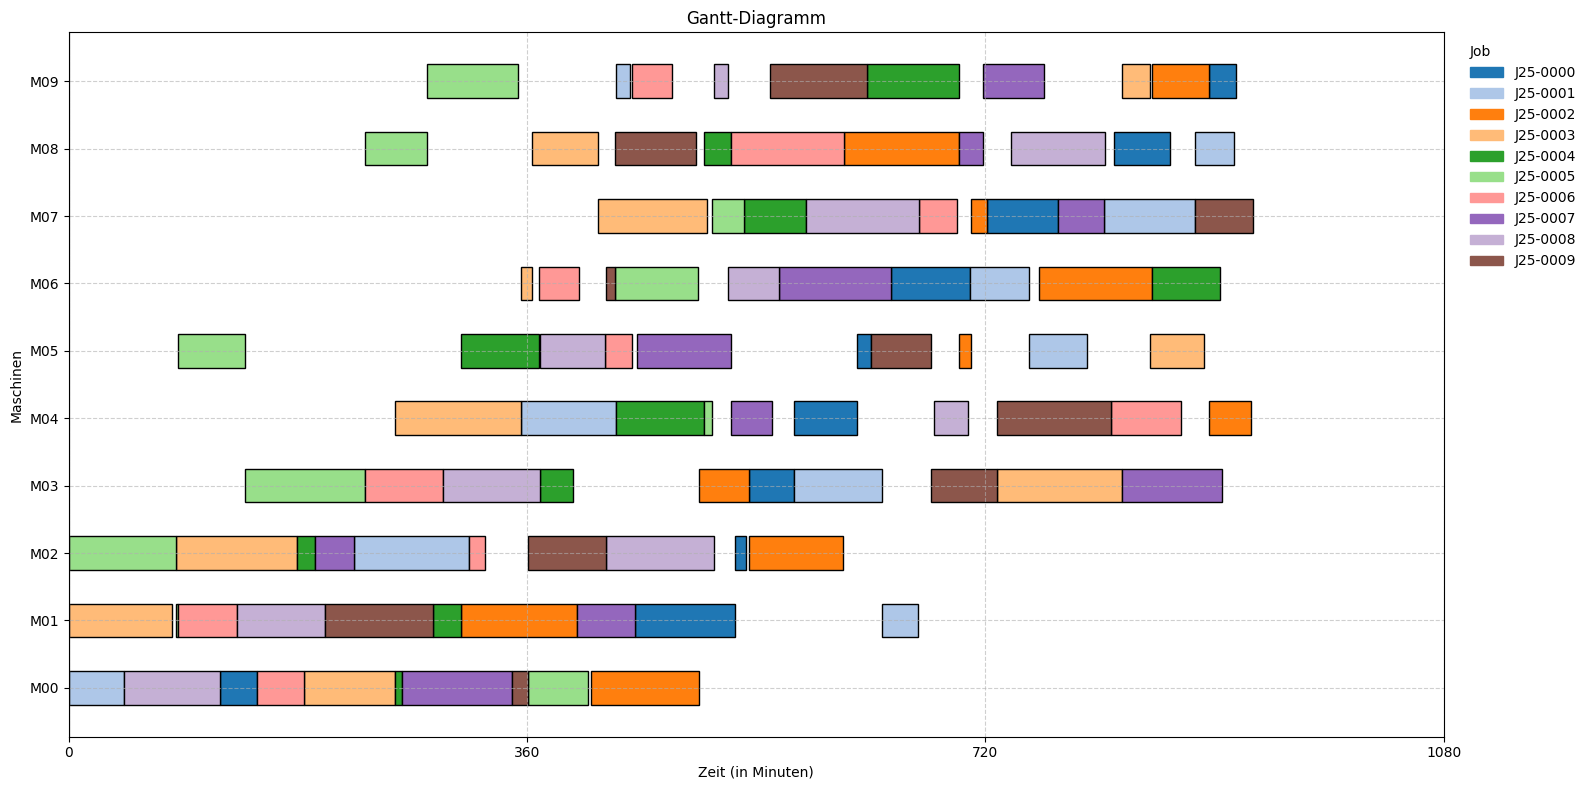

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [9]:
gantt.get_plot(df_schedule, perspective="Machine")
df_schedule_info = pd.merge(df_schedule, df_jobs_arrivals, on="Job", how="right")
check.all_in_one(df_schedule_info)

### b) Flow Time

In [10]:
log_file_path = None # logs_path / "flowtime_cp.log"

schedule = solve_jssp_flowtime_minimization(
    job_ops=job_ops,
    earliest_start=job_earliest_starts,
    schedule_start=0,
    solver_time_limit=max_time,
    msg=True,
    log_file=log_file_path
)
df_schedule = get_schedule_dframe(schedule)
df_schedule

Model Information
  Number of variables       : 213
  Number of constraints     : 313
  Deviation terms (IntVars) : 0

Solver Information:
  Status                   : FEASIBLE
  Objective value          : 7505.0
  Best objective bound     : 6722.0
  Number of branches       : 13
  Wall time                : 601.3381491


,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,0,29,29
1,J25-0000,1,M01,68,78,146
2,J25-0000,2,M02,146,9,155
3,J25-0000,3,M03,170,36,206
4,J25-0000,4,M04,239,49,288
5,J25-0000,5,M05,288,11,299
...,...,...,...,...,...,...
94,J25-0009,4,M08,640,64,704
95,J25-0009,5,M09,774,76,850
96,J25-0009,6,M05,850,47,897


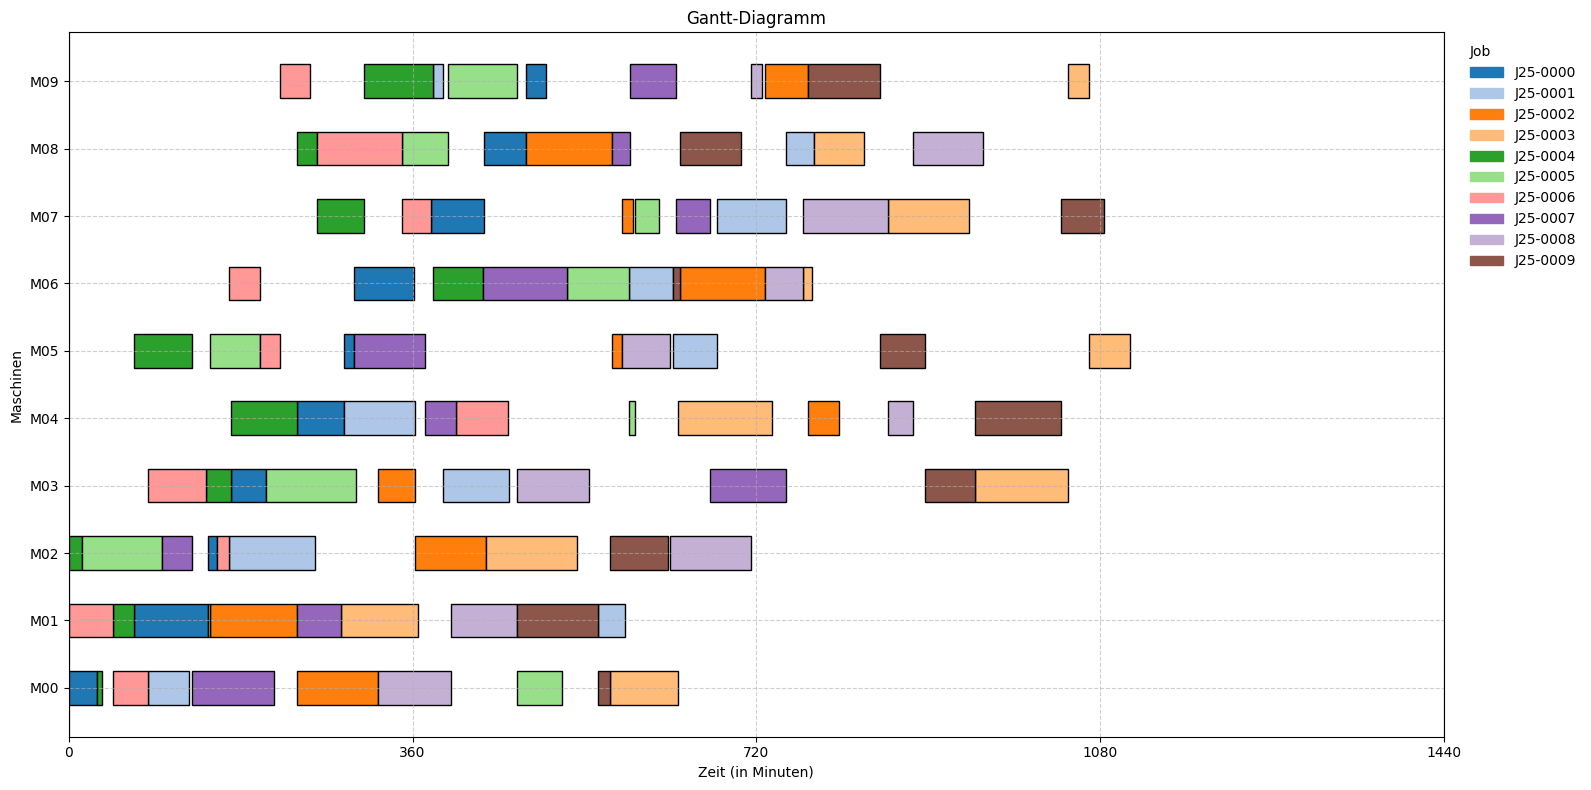

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.



True

In [11]:
gantt.get_plot(df_schedule, perspective="Machine")
df_schedule_info = pd.merge(df_schedule, df_jobs_arrivals, on="Job", how="right")
check.all_in_one(df_schedule_info)